# Preprocessing and model building

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
import joblib
import matplotlib.pyplot as plt
import time

## Preprocessing

### Loading the data

In [2]:
# Loading the data
# Data downloaded from https://www.kaggle.com/datasets/camnugent/california-housing-prices/data as per instruction
df = pd.read_csv('../data/housing.csv')
df.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14763,-117.10,32.59,21.0,2350.0,667.0,1621.0,613.0,2.0734,87500.0,NEAR OCEAN
14586,-117.19,32.84,35.0,2263.0,427.0,1001.0,408.0,3.8750,172000.0,NEAR OCEAN
8599,-118.36,33.87,19.0,2512.0,575.0,1275.0,544.0,4.9375,293000.0,<1H OCEAN
8166,-118.13,33.80,36.0,1496.0,271.0,743.0,265.0,4.4312,226000.0,<1H OCEAN
4576,-118.28,34.07,24.0,3247.0,1281.0,2642.0,1182.0,2.4632,216700.0,<1H OCEAN


### Train/test split
First thing is to split the dataset into training an testing sets. The test set would be set aside until the very end to have a fair estimate of the final model performance
Ideally we should use stratified splitting to make sure the both splits contain the representative data.

As a common practice, we will stratify the splits based on the target variable (median_house_value)

In [3]:
# Creating a temporary category based on the median_house_value to be used for stratification
# The bins are roughly defined by the min, 25%, median, 75%, max values
df['median_house_value_cat'] = pd.cut(df['median_house_value'], bins=[0, 120000, 180000, 265000, 500000, np.inf], labels=[1,2,3,4,5])

<Axes: >

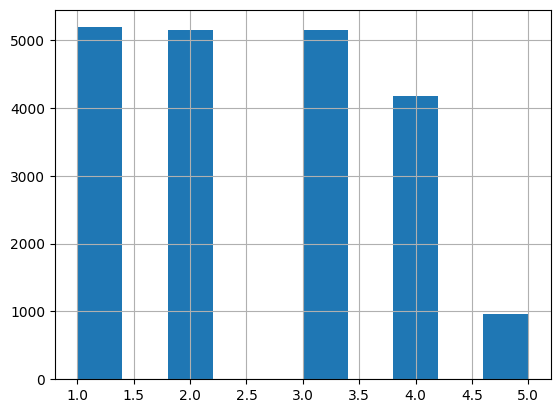

In [4]:
df['median_house_value_cat'].hist()

In [5]:
# We should first generate indices for the rows that would wither be in the training or the test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=1)

# Then going through the generated indices, we create the actual training an test set:
for train_idx, test_idx in split.split(df, df['median_house_value_cat']):
    train_set = df.loc[train_idx]
    test_set = df.loc[test_idx]

In [6]:
# Now we can remove the temporary category that was used for the stratification, from both the train and test splits
train_set.drop('median_house_value_cat', axis=1, inplace=True)
test_set.drop('median_house_value_cat', axis=1, inplace=True)


## Feature Engineering

Based on the EDA and common sense, some features, 

In [7]:
train_set['rooms_per_household'] = train_set['total_rooms'] / train_set['households'] # A measure of average house size (assumption: more rooms per household = larger house)
train_set['bedrooms_per_rooms'] = train_set['total_bedrooms'] / train_set['total_rooms'] # How many bedrooms relative to the total rooms
train_set['income_per_population'] = train_set['median_income'] / train_set['population'] # Average median income per population
train_set['rooms_per_population'] = train_set['total_rooms'] / train_set['population']
train_set['households_per_population'] = train_set['households'] / train_set['population'] # Average household size


In [8]:
train_set.select_dtypes(include='number').corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_rooms,income_per_population,rooms_per_population,households_per_population
longitude,1.000000,-0.924617,-0.108667,0.047647,0.069983,0.100157,0.056671,-0.009521,-0.046549,-0.024141,0.083571,-0.030612,-0.071624,-0.146180
latitude,-0.924617,1.000000,0.011413,-0.040977,-0.069516,-0.110256,-0.073711,-0.085093,-0.144076,0.101740,-0.105828,0.028074,0.137104,0.127604
housing_median_age,-0.108667,0.011413,1.000000,-0.359877,-0.318075,-0.290916,-0.300056,-0.117943,0.107427,-0.143544,0.135500,0.007036,-0.101670,0.019323
total_rooms,0.047647,-0.040977,-0.359877,1.000000,0.930186,0.854971,0.919618,0.201131,0.135090,0.123019,-0.190051,-0.173069,0.117106,0.071085
total_bedrooms,0.069983,-0.069516,-0.318075,0.930186,1.000000,0.874429,0.981670,-0.006391,0.050493,-0.005525,0.085978,-0.202879,0.047029,0.150049
population,0.100157,-0.110256,-0.290916,0.854971,0.874429,1.000000,0.902075,0.005604,-0.026209,-0.072487,0.032510,-0.209364,-0.139940,-0.189274
households,0.056671,-0.073711,-0.300056,0.919618,0.981670,0.902075,1.000000,0.013250,0.065180,-0.083029,0.066797,-0.210388,-0.033412,0.127172
median_income,-0.009521,-0.085093,-0.117943,0.201131,-0.006391,0.005604,0.013250,1.000000,0.682665,0.314330,-0.618029,0.222055,0.226181,-0.011163
median_house_value,-0.046549,-0.144076,0.107427,0.135090,0.050493,-0.026209,0.065180,0.682665,1.000000,0.147088,-0.253310,0.126787,0.201691,0.266251
rooms_per_household,-0.024141,0.101740,-0.143544,0.123019,-0.005525,-0.072487,-0.083029,0.314330,0.147088,1.000000,-0.400864,0.180153,0.887272,-0.000231


In [9]:
# Separating the features and Target variable
X_train = train_set.drop('median_house_value', axis=1)
y_train = train_set['median_house_value'].copy()

## Get the list of numerical and categorical features
num_features = X_train.select_dtypes(include='number').columns
cat_features = X_train.select_dtypes(include='object').columns

## Preprocessing decisions:
### - Imputing the missing values (numerical features)
As a simple method, we'll replace every missing value (of the numerical features) with its median from the training set.
In the current dataset only the total_bedrooms has missing values, but we can keep the median values of all numerical features, in case a missing value is encountered for any of the features after the deployment

### - Scaling numerical features
In order to prevent the bias towards features with relatively larger scales, all numerical features will be scaled to mean=0 and std=1, by subtracting the mean and dividing by variance. This is crucial to be able to compare different ML algorithms as some are senstivive to the scale of features.

### - Handling categorical variables
As most of the ML algorithms expect numerical features, it's always a good idea to create dummy variables for the categorical features (One-hot encoding)

# Model Training

## Creating a pipeline

In [10]:
# A pipeline for numerical features to impute the missing values with the meadian (from training) and then scale them
num_features_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy="median")),
    ('std_saler', StandardScaler())])

# A pipeline (currently containing only a single action) for categorical features to do the one-hot encoding 
cat_features_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder())])

# Combining both pipelines a pipeline
full_pipeline = ColumnTransformer([
    ("num_features", num_features_pipeline, num_features),
    ("cat_features", cat_features_pipeline, cat_features)])

X_train_preprocessed = full_pipeline.fit_transform(X_train)

## Exploring different models using cross-validation and randomized search
The following models are selected to be explored, with the rationale mentioned below:
- (Regularized) Linear regression: A simple model to be used as the baseline
- Random Forests: handles non-linear relationships with low risk of overfitting
- lightGBM (gradient boosting): performs very well on tabular data, handles non-linear relationships and is optimized for memory use (compared to XGBoost)
- KNN: A simple non-parametric algorithm (no assumption is made about the data). However, it does not scale well on large datasets. As long as the end goal for the deployed model is to do single instance inference and not batch, it should be fine.

Why randomized Search instead of e.g., GridSearch? It let's use explore a wider range of hyper parameters for each algorithm by trying random combniations of hyperparameters. 

**Note**: In general, hyper-parameters grids for each of the algorithms are not exhaustive and are chosen to have a trade-off between computation time, model complexity and to prevent overfitting

### Linear Regression (Regularized)

In [11]:
lasso_linear_regressor = Lasso()

# hyperparameters to be tuned (regularization)
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

# RandomizedSearchCV
random_search_lasso = RandomizedSearchCV(
    estimator=lasso_linear_regressor,
    param_distributions=lasso_params,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=1,
    verbose=2,
    n_jobs=-1
)

# Fit the model
random_search_lasso.fit(X_train_preprocessed, y_train)

# Get mean CV RMSE
cv_rmse_lasso = -random_search_lasso.best_score_
print(f"Lasso CV RMSE: {cv_rmse_lasso:.2f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/hamed/MLE/projects/sopra-steria/california-housing/venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/hamed/MLE/projects/sopra-steria/california-housing/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.313e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(
/home/hamed/MLE/projects/sopra-steria/california-housing/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Dua

Lasso CV RMSE: 65925.41


/home/hamed/MLE/projects/sopra-steria/california-housing/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.137e+12, tolerance: 2.070e+10
  model = cd_fast.enet_coordinate_descent(


### Random Forests

In [12]:
rf = RandomForestRegressor(random_state=1)

# hyperparameters grid
rf_params = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=5,  # Cross-validation
    verbose=2,
    random_state=1,
    n_jobs=-1
)

# Fit the model
random_search_rf.fit(X_train_preprocessed, y_train)

# Get mean CV RMSE
cv_rmse_rf = -random_search_rf.best_score_
print(f"Random Forest CV RMSE: {cv_rmse_rf:.2f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .........................................alpha=0.01; total time=   0.8s
[CV] END .........................................alpha=0.01; total time=   0.8s
[CV] END ..........................................alpha=0.1; total time=   0.8s
[CV] END ............................................alpha=1; total time=   0.8s
[CV] END ...........................................alpha=10; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  48.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   3.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total

/home/hamed/MLE/projects/sopra-steria/california-housing/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
140 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
97 fits failed with the following error:
Traceback (most recent call last):
  File "/home/hamed/MLE/projects/sopra-steria/california-housing/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/hamed/MLE/projects/sopra-steria/california-housing/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/hamed/MLE/projects/sopra-s

Random Forest CV RMSE: 50236.95


### LightGBM (Gradient Boosting)

In [13]:
lgb_params = {
    'num_leaves': [20, 31, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_child_samples': [10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=1)

random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_params,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

random_search_lgb.fit(X_train_preprocessed, y_train)
cv_rmse_lgb = -random_search_lgb.best_score_
print(f"LightGBM CV RMSE: {cv_rmse_lgb:.2f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits

[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   4.7s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  12.9s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  13.1s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  33.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10

### KNN

In [14]:
knn_params = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Distance metric: Manhattan (1) or Euclidean (2)
}

knn = KNeighborsRegressor()

random_search_knn = RandomizedSearchCV(
    estimator=knn,
    param_distributions=knn_params,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=1,
    verbose=2,
    n_jobs=-1
)

random_search_knn.fit(X_train_preprocessed, y_train)
cv_rmse_knn = -random_search_knn.best_score_
print(f"k-NN CV RMSE: {cv_rmse_knn:.2f}")


Fitting 5 folds for each of 76 candidates, totalling 380 fits


/home/hamed/MLE/projects/sopra-steria/california-housing/venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 76 is smaller than n_iter=100. Running 76 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 17
[LightGBM] [Info] Start training from score 206595.548207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

## Comparing the models

In [15]:
### Comparing all:

print(f"Lasso: {cv_rmse_lasso:.2f}")
print(f"Random Forest: {cv_rmse_rf:.2f}")
print(f"LightGBM: {cv_rmse_lgb:.2f}")
print(f"k-NN: {cv_rmse_knn:.2f}")

Lasso: 65925.41
Random Forest: 50236.95
LightGBM: 44926.28
k-NN: 57265.09


### Saving the models for future

In [16]:
def save_models(model_objects, version='', metadata={}):
    '''
        A function to dump the model objects together with some metadata and versioning
        model_objects (list): A list containing sklearn randomizedSearchCV objects 
        version (int): an arbitrary version for the model
        metadata (dictionary): A dictionary containing extra metadata such as engineered features
    '''
    timestr = time.strftime("%Y%m%d-%H%M%S")
    
    for model in model_objects:
        # Save model with metadata
        model_data = {
            'model': model.best_estimator_,   
            'metadata':metadata, 
            'params': model.best_params_, 
            'cv_rmse': -model.best_score_,
            'version': version
    }
        joblib.dump(model_data, f'{model.estimator.__class__.__name__}_{timestr}.joblib', compress=True)

In [17]:
# Save the models
models_list = [random_search_lasso, random_search_rf, random_search_lgb, random_search_knn]
save_models(models_list, 1, {'engineered_features': ['rooms_per_household', 'bedrooms_per_rooms','income_per_population','rooms_per_population','households_per_population']})

In [18]:
## Checking the best model (lgb) details

pd.DataFrame(random_search_lgb.cv_results_).iloc[random_search_lgb.best_index_]

mean_fit_time                                                       11.66479
std_fit_time                                                        1.553622
mean_score_time                                                     0.451193
std_score_time                                                       0.04557
param_subsample                                                          0.6
param_num_leaves                                                          50
param_n_estimators                                                      1000
param_min_child_samples                                                   10
param_max_depth                                                         None
param_learning_rate                                                     0.05
param_colsample_bytree                                                   0.8
params                     {'subsample': 0.6, 'num_leaves': 50, 'n_estima...
split0_test_score                                              -46031.260014

## Model Training Conclusions:

- LightGBM has the lowest RMSE of 44926.28. Which means that on average, the model makes an error of 45k when predicting the median price for a block.

- On its own and without knowing about the business requirements and acceptance criteria and the model's intended use, it's difficult to judge if this is an acceptable error or not.

- Given the time and resource constraints in the context of this assignment, the error seems reasonable, but requires further improvements in future.

- On the positive side, by looking at the CV folds errors of the best LightGBM model, the model seem stable (with std of test scores ~ 978) 

- Given that the range of the target variable (median_house_value) is 500000-15000 = 485000 (see EDA), then the 45000 error is roughly 10% of the range, which might be acceptable.

- However looking at the lasso regression as a baseline, it improves the CV error on the training set by ~30% which is significant.


## Feature Importance:

In [19]:
feature_importance = random_search_lgb.best_estimator_.feature_importances_

# Map feature importance to feature names
one_hot_enc_features = list(full_pipeline.named_transformers_.cat_features.get_feature_names_out())
all_features = list(num_features) + one_hot_enc_features

feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

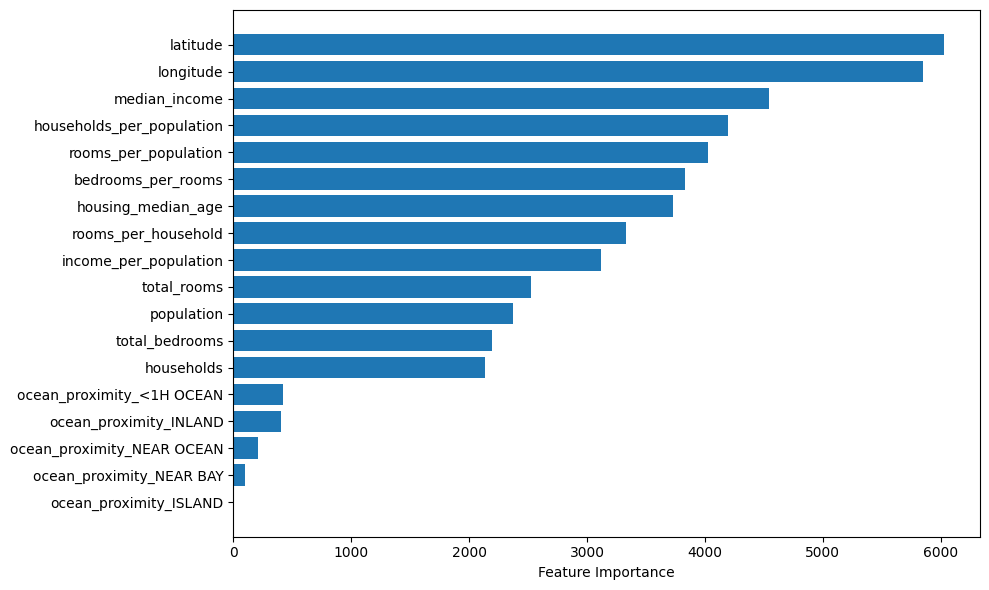

In [20]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

### Conclusions:
- lat, long, and median income are the top predictors as expected from the EDA
- The engineered feature: housholds per population (as a measure of average household size per block) is also considered important

# Retrain the model on the full training set:

To use all the information in the training set, it's beneficial to retrain the best model one last time on the full training set.

Keep in mind that we only update the model paramters and hyper-parameters are not touched (they are the same as found by the randomizedSearchCV)

In [21]:
best_model = random_search_lgb.best_estimator_

best_model.fit(X_train_preprocessed, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 15480, number of used features: 17
[LightGBM] [Info] Start training from score 207060.027132


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=None,
              min_child_samples=10, n_estimators=1000, num_leaves=50,
              random_state=1, subsample=0.6)

# Evaluate on the test set

Note: According to best practices and to prevent data leakage, we should not update the model once it's evaluated on the test set.

In [22]:
# Prepare the test set
X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value'].copy()

# Create the engineered features
X_test['rooms_per_household'] = X_test['total_rooms'] / X_test['households'] # A measure of average house size (assumption: more rooms per household = larger house)
X_test['bedrooms_per_rooms'] = X_test['total_bedrooms'] / X_test['total_rooms']
X_test['income_per_population'] = X_test['median_income'] / X_test['population'] # Average median income per population
X_test['rooms_per_population'] = X_test['total_rooms'] / X_test['population']
X_test['households_per_population'] = X_test['households'] / X_test['population'] # Average household size


# Transform the test set using the full pipeline
X_test_preprocessed = full_pipeline.transform(X_test)

# Make predictions
best_predictions = best_model.predict(X_test_preprocessed)

# Evaluate
rmse_test = np.sqrt(mean_squared_error(y_test, best_predictions))


In [23]:
rmse_test

np.float64(42636.85870692916)

## Conclusion:
The error on the test set (~ 42000) seems to be aligned with the training CV error (~45000), which suggests that the model is robust and can generalize well on unseen data

# Save the final model and preprocessing pipeline for deployment
It is also a good idea to retrain again on the full dataset (training + test) before deplying it, if the decision on the algorithm, (hyper)parameters, and overal performance is **final** and we are sure that we **won't** do any iterations to imrpove the model. However since there are no other independant test sets available (for the evaluator to check the model performance after deployment, and through the API, I chose not to do that at this stage. 

In [24]:
timestr = time.strftime("%Y%m%d-%H%M%S")
# Save the final best model
joblib.dump(best_model, f'best_model_lgb_{timestr}_v1.joblib')

# Save the pipeline
joblib.dump(full_pipeline, f'preprocessing_pipeline_{timestr}_v1.joblib')

['preprocessing_pipeline_20241201-123432_v1.joblib']


[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.5s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.3s
[CV] END ................n_neighbors=1, p=2, weights=uniform; total time=   0.3s
[CV] END ................n_neighbors=1, p=2, weights=uniform; total time=   0.3s
[CV] END ...............n_neighbors=1, p=2, weights=distance; total time=   0.3s
[CV] END ...............n_neighbors=1, p=2, weights=distance; total time=   0.3s
[CV] END ................n_neighbors=2, p=1, weights=uniform; total time=   1.3s
[CV] END ...............n_neighbors=2, p=1, weights=distance; total time=   1.3s
[CV] END ...............n_neighbors=2, p=1, weights=distance; total time=   1.3s
[CV] END ...............n_neighbors=2, p=2, weights=distance; total time=   0.3s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.3s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   1.3s
[CV] END ...............n_n